#$Question$:

##Look into twitter text data to predict if the given text has positive or negative sentiment towards a particular brand. The dataset includes twitter text related to Apple and Google products with user sentiment ranked between ‘positive’,‘negative’, ‘neutral’ and ‘no_idea’, sentiments. Create a simple RNN or LSTM based classifiers to classify tweets into the four classes. You can avoid ‘emotion_in_tweet_is_directed_at’ column.
---
---

## 1. Data Loading and Initial Exploration

In [ ]:
# It loads the dataset and performs initial exploration.
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping

#----------Load the dataset-------------------
try:
    df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='latin-1')

#----------------Display the first few rows--------------
print("\n--- First 5 rows of the dataset ---")
print("*"*len("--- First 5 rows of the dataset ---"))
print(df.head())

#---------------Get dataset information------------------
print("\n--- Dataset Info ---")
print("-"*len("--- Dataset Info ---"))
print(df.info())
print("\n ----Columns are----")
print("-"*len("----Columns are----"))
print(df.columns)
# Check the distribution of sentiment classes
print("\n--- Sentiment Class Distribution ---")
print("="*len('--- Sentiment Class Distribution ---'))
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())




--- First 5 rows of the dataset ---
***********************************
                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  

--- Dataset Info ---
---------------

In [ ]:
# Define the mapping for emotions
emotion_mapping = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral',
    "I can't tell": 'no_idea'
}

# Apply the mapping to the 'is_there_an_emotion_directed_at_a_brand_or_product' column
df['sentiment'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace(emotion_mapping)

# Display the updated DataFrame
print("\n--- Updated Dataframe ---")
print("*"*len('--- Updated Dataframe ---'))
print(df[['tweet_text', 'sentiment']].head())

# Check the distribution of the new sentiment classes
print("\n--- New Sentiment Class Distribution ---")
print("#"*len('--- New Sentiment Class Distribution ---'))
print(df['sentiment'].value_counts())


--- Updated Dataframe ---
*************************
                                          tweet_text sentiment
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...  Negative
1  @jessedee Know about @fludapp ? Awesome iPad/i...  Positive
2  @swonderlin Can not wait for #iPad 2 also. The...  Positive
3  @sxsw I hope this year's festival isn't as cra...  Negative
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...  Positive

--- New Sentiment Class Distribution ---
########################################
sentiment
Neutral     5389
Positive    2978
Negative     570
no_idea      156
Name: count, dtype: int64


In [ ]:
if 'emotion_in_tweet_is_directed_at' in df.columns:
    df = df.drop('emotion_in_tweet_is_directed_at', axis=1)
    print("Dropped 'emotion_in_tweet_is_directed_at' column.")

Dropped 'emotion_in_tweet_is_directed_at' column.


In [ ]:
# Keep only 'tweet_text' and 'sentiment' columns
df = df[['tweet_text', 'sentiment']]

In [ ]:
df.isnull().sum()

,0
tweet_text,1
sentiment,0


In [ ]:
df.dropna(inplace=True)

/tmp/ipython-input-47-501717308.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


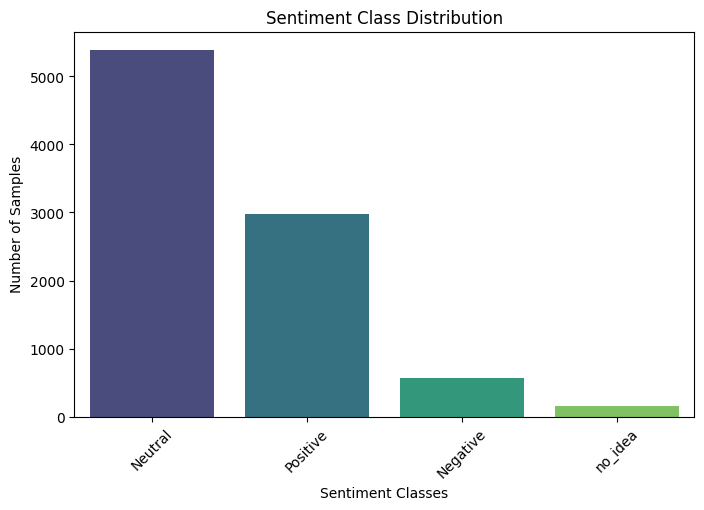

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the class distribution
class_distribution = df['sentiment'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

##2.Data Pre-processing

In [ ]:
# It performs data cleaning, label encoding, tokenization, and padding.

# Use the original dataframe directly without filtering 'No emotion toward brand or product'
df_processed = df.copy() # Create a copy to avoid modifying the original df

# Select relevant columns - Use the original sentiment column as target
X = df_processed['tweet_text']
y = df_processed['sentiment'].copy() # Create a copy

# Handle the single missing tweet_text value
X.fillna('', inplace=True)

#-----------Text Cleaning Function------------------------------------
# clean_text function is already defined in a previous cell

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text
X_cleaned = X.apply(clean_text)

print("\n--- Cleaned Tweet Examples ---")
print(X_cleaned.head())

#--------------------- Label Encoding for target variable-------------------
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("\n--- Original Labels and Encoded Labels Mapping ---")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

#------------------------- Tokenization---------------------------------------
max_words = 10000 # Maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_words, oov_token="<unk>")
tokenizer.fit_on_texts(X_cleaned)
X_sequences = tokenizer.texts_to_sequences(X_cleaned)

#-----------Determine maximum sequence length for padding-----------------------
max_sequence_length = max([len(x) for x in X_sequences])
print(f"\nMaximum sequence length: {max_sequence_length}")

#------------------------- Padding sequences---------------------------
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post')

print(f"\nShape of padded sequences (X_padded): {X_padded.shape}")
print(f"Shape of one-hot encoded labels (y_categorical): {y_categorical.shape}")

#------------------------- Train-Test Split-------------------------------
# Use stratify with the original encoded labels (y_encoded) for 4 classes
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


--- Cleaned Tweet Examples ---
0     i have a 3g iphone after 3 hrs tweeting at  i...
1     know about   awesome ipadiphone app that youl...
2     can not wait for  2 also they should sale the...
3     i hope this years festival isnt as crashy as ...
4     great stuff on fri  marissa mayer google tim ...
Name: tweet_text, dtype: object

--- Original Labels and Encoded Labels Mapping ---
Negative: 0
Neutral: 1
Positive: 2
no_idea: 3

Maximum sequence length: 31

Shape of padded sequences (X_padded): (9092, 31)
Shape of one-hot encoded labels (y_categorical): (9092, 4)

Shape of X_train: (7273, 31)
Shape of X_test: (1819, 31)
Shape of y_train: (7273, 4)
Shape of y_test: (1819, 4)


##3.Model Definition

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Model Parameters
embedding_dim = 100  # Dimension of the dense embedding
lstm_units = 128     # Number of LSTM units
num_classes = y_categorical.shape[1]  # Number of sentiment classes

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary ---")
model.summary()



--- Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##4. Model Training

In [ ]:
# Train the model
epochs = 10
batch_size = 32

print(f"\n--- Training the LSTM Model for {epochs} epochs with batch size {batch_size} ---")
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,  # Use 10% of training data for validation
                    verbose=1)

print("\n--- Training Complete ---")



--- Training the LSTM Model for 10 epochs with batch size 32 ---
Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 30s 116ms/step - accuracy: 0.5390 - loss: 1.0347 - val_accuracy: 0.6044 - val_loss: 0.8910
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.6526 - loss: 0.8595 - val_accuracy: 0.6497 - val_loss: 0.8335
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.7244 - loss: 0.7430 - val_accuracy: 0.6635 - val_loss: 0.8799
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.7684 - loss: 0.6480 - val_accuracy: 0.6758 - val_loss: 0.8741
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.7925 - loss: 0.6091 - val_accuracy: 0.6772 - val_loss: 0.8694
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.8149 - loss: 0.5426 - val_accuracy: 0.6044 - val_loss: 1.0269
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.8228 - loss: 0.5237 - val_accuracy: 0.6731 - val_loss: 0.9536
Epoch 8/10
205/20

##5.Model Evaluation


--- Evaluating Model on Test Set ---
Test Loss: 0.3986
Test Accuracy: 0.8622
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.94      1.00      0.97      1078
     Neutral       0.79      0.65      0.72      1077
    Positive       0.74      0.81      0.77      1078
     no_idea       0.97      0.99      0.98      1078

    accuracy                           0.86      4311
   macro avg       0.86      0.86      0.86      4311
weighted avg       0.86      0.86      0.86      4311


--- Confusion Matrix ---
[[1076    0    0    2]
 [  51  704  303   19]
 [  11  186  868   13]
 [   9    0    0 1069]]


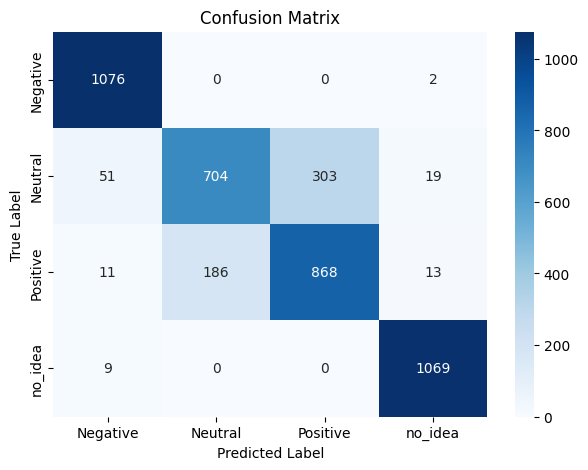

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
print("\n--- Evaluating Model on Test Set ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Example of predicting sentiment for new tweets
new_tweets = [
    "I love my new iPhone, it's amazing!",
    "Google's new social network is a disaster.",
    "The iPad 2 is pretty good.",
    "This product is neither good nor bad."
]

# Clean the new tweets
new_tweets_cleaned = [clean_text(tweet) for tweet in new_tweets]

# Convert new tweets to sequences
new_sequences = tokenizer.texts_to_sequences(new_tweets_cleaned)

# Pad the sequences
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post')

# Predict sentiment
new_predictions_probs = model.predict(new_padded)
new_predictions = np.argmax(new_predictions_probs, axis=1)

print("\n--- Predictions for New Tweets ---")
for i, tweet in enumerate(new_tweets):
    predicted_sentiment = label_encoder.inverse_transform([new_predictions[i]])[0]
    print(f"Tweet: '{tweet}'")
    print(f"Predicted Sentiment: {predicted_sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

--- Predictions for New Tweets ---
Tweet: 'I love my new iPhone, it's amazing!'
Predicted Sentiment: Positive

Tweet: 'Google's new social network is a disaster.'
Predicted Sentiment: Neutral

Tweet: 'The iPad 2 is pretty good.'
Predicted Sentiment: Positive

Tweet: 'This product is neither good nor bad.'
Predicted Sentiment: no_idea



##OVERSAMPLING TO AVOID DATA UNBALANCING

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 66s 117ms/step - accuracy: 0.3703 - loss: 1.2430 - val_accuracy: 0.7183 - val_loss: 0.5699
Epoch 2/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.6970 - loss: 0.5812 - val_accuracy: 0.7374 - val_loss: 0.5109
Epoch 3/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 82s 116ms/step - accuracy: 0.7236 - loss: 0.4842 - val_accuracy: 0.7084 - val_loss: 0.4877
Epoch 4/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 82s 115ms/step - accuracy: 0.7314 - loss: 0.4528 - val_accuracy: 0.7699 - val_loss: 0.4282
Epoch 5/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 82s 116ms/step - accuracy: 0.7507 - loss: 0.4309 - val_accuracy: 0.7623 - val_loss: 0.4466
Epoch 6/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.7694 - loss: 0.4282 - val_accuracy: 0.8330 - val_loss: 0.4006
Epoch 7/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.8605 - loss: 0.3513 - val_accuracy: 0.8423 - val_loss: 0.3957
Epoch 8/10
485/485 ━━━━━━━━━━━━━━━━━━━━ 84s 118ms/step - accuracy: 0.9108 - loss: 0

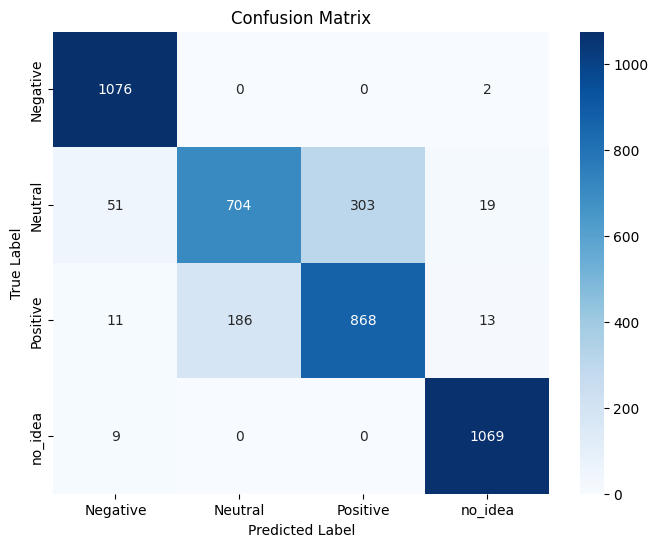

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

--- Predictions for New Tweets ---
Tweet: 'I love my new iPhone, it's amazing!'
Predicted Sentiment: Positive

Tweet: 'Google's new social network is a disaster.'
Predicted Sentiment: Neutral

Tweet: 'The iPad 2 is pretty good.'
Predicted Sentiment: Positive

Tweet: 'This product is neither good nor bad.'
Predicted Sentiment: no_idea



In [ ]:
# Oversample after padding and encoding but before train/test split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_padded, y_encoded)

# One-hot encode the new oversampled labels for Keras
y_ros_categorical = to_categorical(y_ros)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_ros, y_ros_categorical, test_size=0.2, random_state=42, stratify=y_ros
)

# (Re)Define and train your LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 100
lstm_units = 128
num_classes = y_ros_categorical.shape[1]

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=X_train.shape[1]))
model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions and evaluate metrics
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Predict sentiment of new tweets
new_tweets = [
    "I love my new iPhone, it's amazing!",
    "Google's new social network is a disaster.",
    "The iPad 2 is pretty good.",
    "This product is neither good nor bad."
]
new_tweets_cleaned = [clean_text(tweet) for tweet in new_tweets]
new_sequences = tokenizer.texts_to_sequences(new_tweets_cleaned)
new_padded = pad_sequences(new_sequences, maxlen=X_train.shape[1], padding='post')
new_predictions_probs = model.predict(new_padded)
new_predictions = np.argmax(new_predictions_probs, axis=1)

print("\n--- Predictions for New Tweets ---")
for i, tweet in enumerate(new_tweets):
    predicted_sentiment = label_encoder.inverse_transform([new_predictions[i]])[0]
    print(f"Tweet: '{tweet}'")
    print(f"Predicted Sentiment: {predicted_sentiment}\n")
